# [Yelp Dataset Challenge](http://www.yelp.com/dataset_challenge)
**Rakesh Chada** and **Chetan Naik**

---

## <a id='baseline'>NMF + Sentiment Model</a>

#### 1.1 Importing necessary libraries

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [32]:
import time
import datetime

import cPickle as pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn
import sklearn.feature_extraction.text as text

from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn import decomposition

plt.rc('figure', figsize=(10,6))
seaborn.set()
colors = seaborn.color_palette()

#### 1.2 Read csv files using pandas library.

In [23]:
business_data = pd.read_csv('yelp_academic_dataset_business.csv', dtype=unicode)
checkin_data = pd.read_csv('yelp_academic_dataset_checkin.csv')
review_data = pd.read_csv('yelp_academic_dataset_review.csv')
tip_data = pd.read_csv('yelp_academic_dataset_tip.csv')
user_data = pd.read_csv('yelp_academic_dataset_user.csv')

#### 1.3 Merge pandas dataframes.

In [24]:
review_user_data = review_data.merge(user_data,
                                     left_on='user_id',
                                     right_on='user_id',
                                     how='outer',
                                     suffixes=('_review', '_user'))

In [25]:
business_review_user_data = review_user_data.merge(business_data,
                                                   left_on='business_id',
                                                   right_on='business_id',
                                                   how='outer',
                                                   suffixes=('_reviewuser', '_business'))

In [26]:
cols = business_review_user_data.columns
cols = cols.map(lambda x: x.replace(' ', '_').lower() if isinstance(x, (str, unicode)) else x)
business_review_user_data.columns = cols
firstFewRows = business_review_user_data.ix[:,['categories','text','stars_reviewuser','business_id']]
firstFewRowsList = firstFewRows['categories'].tolist()
restaurantsDF = firstFewRows[firstFewRows['categories'].str.contains('Restaurants')]

In [27]:
t = restaurantsDF.dropna(how='all')

In [28]:
minReviewLen = 50
maxReviewLen = 100

print "Number of rows selected:",len(t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen])
restaurantsDF = t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen]

Number of rows selected: 28148


In [29]:
trainData = restaurantsDF
trainLabel = trainData.stars_reviewuser
trainDocuments = trainData.text.tolist()

In [33]:
vectorizer = text.CountVectorizer(stop_words='english', min_df=2)

In [34]:
trainVectors = vectorizer.fit_transform(trainDocuments).toarray()

In [35]:
vocab = np.array(vectorizer.get_feature_names())

In [36]:
# vocab[:50]

In [37]:
trainVectors.shape

(28148, 6072)

In [38]:
len(vocab)

6072

By analogy with LDA, we will use NMF to get a document-topic matrix (topics here will also be referred to as “components”) and a list of top words for each topic. We will make analogy clear by using the same variable names: doctopic and topic_words

In [39]:
num_topics = 20
num_top_words = 20

In [40]:
clf = decomposition.NMF(n_components=num_topics, random_state=1)

In [41]:
trainTopics = clf.fit_transform(trainVectors)

/usr/local/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:533: UserWarning: Iteration limit reached during fit
  warnings.warn("Iteration limit reached during fit")


To make the analysis and visualization of NMF components similar to that of LDA’s topic proportions, we will scale the document-component matrix such that the component values associated with each document sum to one.

In [43]:
trainTopics = trainTopics / np.sum(trainTopics, axis=1, keepdims=True)

Now we will average those topic shares associated with the same document together.

In [44]:
d, f = trainTopics.shape
cols = ["Topic"+str(i) for i in xrange(1, f+1)]
nmfDF = pd.DataFrame(trainTopics, columns=cols)

In [45]:
nmfDF['rating'] = trainLabel.tolist()

In [46]:
nmfDF.T.head(25)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
Topic1,0.003596,-0.000000,0.000700,0.001338,0.002576,0.271052,-0.000000,0.037194,0.142859,0.014129,-0.000000,0.612284,-0.000000,0.054807,0.005885,0.035427,0.007599,0.003179,0.021855,0.000936,...
Topic2,0.006625,0.820254,0.003418,0.002628,0.006347,-0.000000,0.053463,0.033165,0.209341,0.004821,-0.000000,0.000996,-0.000000,0.091439,0.009098,0.036150,0.004102,0.269843,0.011229,0.003009,...
Topic3,0.003749,-0.000000,-0.000000,-0.000000,-0.000000,0.000038,0.082376,0.016682,0.210397,0.010952,-0.000000,0.011889,-0.000000,0.078675,0.001206,0.015217,-0.000000,0.267327,0.010999,-0.000000,...
Topic4,0.008004,0.004272,0.345407,0.007786,0.012103,0.000483,0.014797,0.031806,-0.000000,0.036138,-0.000000,-0.000000,-0.000000,0.013888,0.017561,0.023166,0.089337,0.009315,0.011000,0.847817,...
Topic5,0.011277,-0.000000,-0.000000,-0.000000,-0.000000,0.000980,0.006293,0.002481,0.179843,0.017274,-0.000000,0.005566,0.332980,-0.000000,-0.000000,0.031332,0.001998,-0.000000,0.590430,0.001490,...
Topic6,0.493228,0.005805,0.005476,0.349986,0.008353,0.411736,-0.000000,0.004758,-0.000000,0.037638,-0.000000,0.008926,-0.000000,-0.000000,0.010731,0.047863,-0.000000,0.277493,0.010738,0.012146,...
Topic7,0.019848,0.007958,-0.000000,-0.000000,-0.000000,-0.000000,0.042302,0.020857,0.005892,0.022791,-0.000000,0.031092,-0.000000,0.023636,-0.000000,0.013369,0.022949,0.003639,-0.000000,0.007983,...
Topic8,0.007014,0.012278,0.345506,0.004302,0.008079,-0.000000,0.003782,0.031046,-0.000000,0.073922,-0.000000,0.017856,-0.000000,0.009147,0.009022,-0.000000,0.022208,0.008453,0.023162,0.007574,...
Topic9,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.013942,-0.000000,0.001047,-0.000000,-0.000000,0.261247,0.053448,0.000060,0.001662,0.015955,0.004712,-0.000000,-0.000000,...
Topic10,0.046897,0.023847,0.002417,0.001500,0.003674,-0.000000,0.016499,0.085457,0.002121,0.118229,-0.000000,0.002351,-0.000000,0.011316,0.010257,0.025151,0.040138,0.017663,0.038122,0.025155,...


In [47]:
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1

In [48]:
nmfDF['Sentiment'] = nmfDF['rating'].map(getSentiment)

In [49]:
nmfDF = nmfDF.dropna(how='any')

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [51]:
cols = [u'Topic1', u'Topic2', u'Topic3', u'Topic4', u'Topic5', u'Topic6', u'Topic7', u'Topic8', u'Topic9', u'Topic10', u'Topic11', u'Topic12', u'Topic13', u'Topic14', u'Topic15', u'Topic16', u'Topic17', u'Topic18', u'Topic19', u'Topic20', u'Sentiment']
Xtrain = nmfDF[:10000][cols]
Ytrain = nmfDF[:10000]['rating']
Xtest = nmfDF[10000:][cols]
Ytest = nmfDF[10000:]['rating']

In [52]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), LDA(), QDA(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'LDA', 'QDA', 'Random Forest', 'AdaBoost']
results = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(Xtrain, Ytrain)
    preds = clf.predict(Xtest)
    
    precision = metrics.precision_score(Ytest, preds)
    recall = metrics.recall_score(Ytest, preds)
    f1 = metrics.f1_score(Ytest, preds)
    accuracy = accuracy_score(Ytest, preds)
    report = classification_report(Ytest, preds)
    matrix = metrics.confusion_matrix(Ytest, preds, labels=[1, 2, 3, 4, 5])
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    results[clf_names[i]] = data

cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(results).T[cols].T

/usr/local/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/site-packages/sklearn/lda.py:161: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python2.7/site-packages/sklearn/qda.py:124: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,AdaBoost,LDA,Logistic Regression,Multinomial Naive Bayes,Nearest Neighbors,QDA,Random Forest
precision,0.5925293,0.4618533,0.5990594,0.4024768,0.5702918,0.005858613,0.6019879
recall,0.6077589,0.4990908,0.6137103,0.4852042,0.5708382,0.07654158,0.6107897
f1_score,0.5936709,0.4515556,0.5847279,0.3860613,0.5705237,0.01088414,0.6006397
accuracy,0.6077589,0.4990908,0.6137103,0.4852042,0.5708382,0.07654158,0.6107897


In [53]:
for model, val in results.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'Here is the classification report:'
    print val['clf_report']

----------
MODEL: LDA
----------
The precision for this classifier is 0.461853251358
The recall for this classifier is    0.499090758803
The f1 for this classifier is        0.451555568872
The accuracy for this classifier is  0.499090758803
Here is the classification report:
             precision    recall  f1-score   support

        1.0       0.38      0.13      0.20      1389
        2.0       0.21      0.17      0.19      1015
        3.0       0.34      0.02      0.04      2036
        4.0       0.44      0.41      0.43      5625
        5.0       0.56      0.78      0.65      8082

avg / total       0.46      0.50      0.45     18147

----------
MODEL: QDA
----------
The precision for this classifier is 0.00585861302805
The recall for this classifier is    0.0765415771202
The f1 for this classifier is        0.0108841370414
The accuracy for this classifier is  0.0765415771202
Here is the classification report:
             precision    recall  f1-score   support

        1.0    

## Error Metrics

In [54]:
def central_tendency_plot(point, ci, y, color, label):
    plt.plot(ci, [y, y], "-", color=color, linewidth=4, label=label)
    plt.plot(point, y, "o", color=color, markersize=10)
    
def plot_error_dist(column, name):
    d = column.tolist()
    d = [0 if math.isnan(x) else x for x in d]
    m = mean(d)
    med = median(d)
    s = std(d)

    x = linspace(min(d), max(d), 1000)
    gauss = lambda x, m, s: (1 / (s * sqrt(2 * pi)) * exp(-0.5 * ((x - m) / s) ** 2))
    y = gauss(x, m, s)

    bins = np.arange(min(d), max(d)+1, 1)
    n, b, patches = plt.hist(d, bins=bins+1, normed=True, align='left', width=0.95)
    xticks(bins)
    bin_max = np.max(n)
    m_y = bin_max/5
    
    central_tendency_plot(m, [m - s, m + s], m_y, colors[1], "std dev")

    ci = np.percentile(d, [16, 84])
    central_tendency_plot(med, ci,  m_y - bin_max/10, colors[2], "68% CI")
    
    plt.legend()
    plt.plot(x, y, color=colors[4])
    plt.xlabel('Error')
    plt.ylabel('Normalized Frequency')
    title = name + ' Error Distribution'
    plt.title(title)
    plt.show()

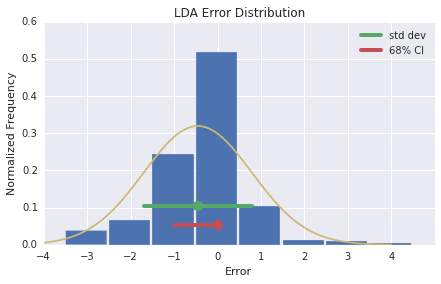

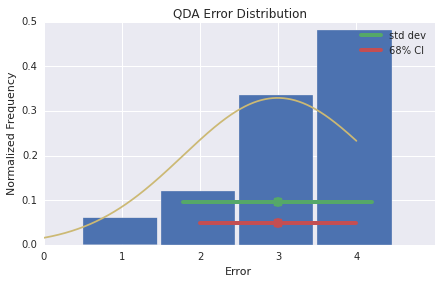

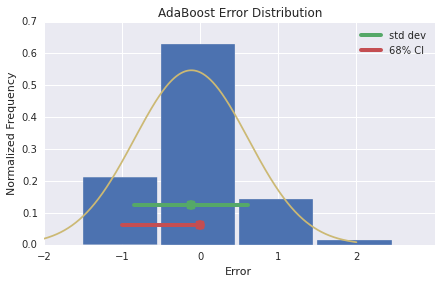

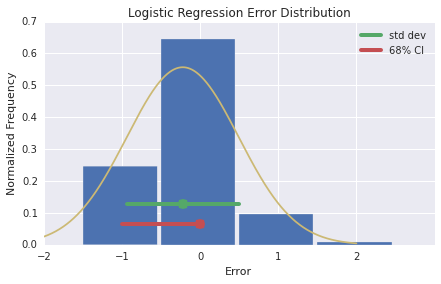

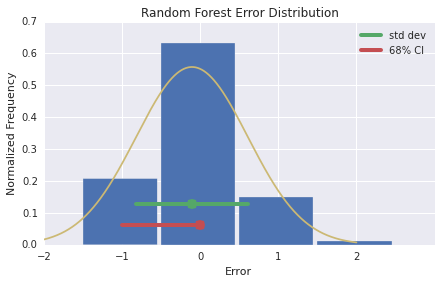

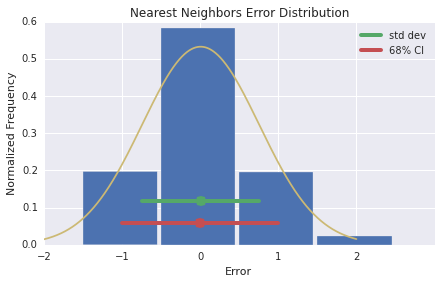

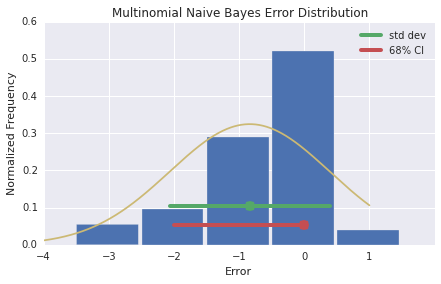

In [55]:
for model, val in results.iteritems():
    plt.rc('figure', figsize=(7,4))
    Xtest['predicted_rating'] = val['y_predicted']
    Xtest['rating'] = Ytest
    Xtest['error'] = Xtest.rating - Xtest.predicted_rating
    plot_error_dist(Xtest.error, model)